In [46]:
import csv
import gensim
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from key_words_extract import *

from tqdm import tqdm

from scipy.spatial.distance import cosine

from keras.preprocessing import sequence, text
from keras.utils.np_utils import to_categorical


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [29]:
RANDOM_SEED = 42
NB_CATEGORIES = 51
PADDING = 100
PRE_TRAINED_DIM = 300
REDUCED_DIM = 100
NB_KEYWORDS = 10

dataDirPath = './challenge_data'
embeddingsDirPath = './../word_embeddings/'
xPath = os.path.join(dataDirPath, 'input_train.csv')
yPath = os.path.join(dataDirPath, 'output_train.csv')
xTestPath = os.path.join(dataDirPath, 'input_test.csv')
#embeddingPath = os.path.join(embeddingsDirPath, 'wiki.fr.vec')
#embeddingPath = os.path.join(embeddingsDirPath, 'retrained_fr.vec')
embeddingPath = os.path.join(embeddingsDirPath, 'retrained_questions.vec')

## Loading Word Embeddings

In [3]:
'''pretrainedEmbeddings = gensim.models.KeyedVectors.\
    load_word2vec_format(embeddingPath, binary=False)'''

## Load data

In [30]:
x = pd.read_csv(xPath, delimiter=';', usecols=[1]).values.ravel()
xTest = pd.read_csv(xTestPath, delimiter=';', usecols=[1]).values.ravel()
y = pd.read_csv(yPath, delimiter=';', usecols=[1]).values.ravel()

## Preprocessing

In [31]:
correctionsDict = {}
correctionsPath = os.path.join(dataDirPath, 'corrections.csv')

with open(correctionsPath, 'r') as f:
    for key, val in csv.reader(f):
        correctionsDict[key] = val

def spellingCorrection(sentence, correctionsDict={}, verbose=False):
    correctedSentence = []
    nb_corrections = 0
    for word in sentence.split():
        if word in correctionsDict.keys():
            word = correctionsDict[word]
            nb_corrections += 1
        correctedSentence.append(word)
    if verbose:
        return ' '.join(correctedSentence), nb_corrections
    else:
        return ' '.join(correctedSentence)

nb_corr = 0
for i, s in enumerate(x):
    cor = spellingCorrection(s, correctionsDict, verbose = True)
    x[i] = cor[0]
    nb_corr += cor[1]

for i, s in enumerate(xTest):
    cor = spellingCorrection(s, correctionsDict, verbose = True)
    xTest[i] = cor[0]
    nb_corr += cor[1]
print(nb_corr)

7973


In [37]:
class CustomModel():
    '''Generic workflow class.'''

    def __init__(self, **kwargs):
        self.verbose = kwargs.get('verbose', False)
        self.nbCategories = kwargs['nbCategories']
        self.paddingLength = PADDING
        self.tokenizer = text.Tokenizer(num_words=1e5, 
                                        filters="!\"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'´’™©®«»",
                                        split=" ")
    
    def tokenizer_fit(self, x):
        self.tokenizer.fit_on_texts(x)
    
    def tokenize(self, x):
        x = self.tokenizer.texts_to_sequences(x)
        x = sequence.pad_sequences(x, PADDING)
        return x
    
    def buildKeywords(self, x, y, k):
        self.kwords, self.kweights = keyWordsExtract(x=x, y=y, k=k, toVector=True)
        return self.kwords
        
    def build_tfidf(self, x, xTest=None):
        self.tfidf = TfidfVectorizer(input = 'content')
        xTrain = self.tfidf.fit_transform(x)
        if xTest is not None:
            xTest = self.tfidf.transform(xTest)
            return xTrain, xTest
        else:
            return xTest

    def buildFeatures(self, x, k, embeddings):
        x_feat = np.zeros((x.shape[0], k*self.nbCategories))
        kindices = np.array([self.tokenizer.word_index[w] for w in self.kwords])
        print(x.shape)
        for i in tqdm(np.arange(x.shape[0])):
            xx = x[i]
            for j, keyword in enumerate(kindices):
                if keyword in xx:
                    x_feat[i, j] = 1
        return x_feat
    
    def train_xgboost(self, x, y):
        return
       
    def evaluate(self, x, y):
        return self.model.evaluate(x, y)

    def predict(self, x):
        return self.model.predict(x)

### Tokenizing

In [38]:
# we need to create the model here
model = CustomModel(verbose=True, nbCategories=NB_CATEGORIES)
model.tokenizer_fit(np.concatenate((x, xTest)))
vocabulary = model.tokenizer.word_index.keys()
print('Vocabulary size: ', len(vocabulary))

Vocabulary size:  10175


#### TFIDF features

In [39]:
xTrain_tf, xTest_tf = model.build_tfidf(x, xTest)

#### Keywords features

In [40]:
# if a dictionnary {cat: [keywords]} is wanted, set toVector = False
model.buildKeywords(x, y, k = NB_KEYWORDS)

x = model.tokenize(x)
xTest = model.tokenize(xTest)
#y = to_categorical(y, num_classes=NB_CATEGORIES)

In [41]:
MEDICAMENTS = []

with open(os.path.join(dataDirPath, 'medicList.txt')) as f:
    for line in f:
        MEDICAMENTS.append(line.lower().rstrip())

print('Liste de médicaments regroupant les libéllés ATC et les'
      'dénominations de spécialité, de taille: {}'.format(len(MEDICAMENTS)))
print('Sample of medicament names: ', MEDICAMENTS[:10])

Liste de médicaments regroupant les libéllés ATC et lesdénominations de spécialité, de taille: 8390
Sample of medicament names:  ['a 313 200  pour cent', 'a 313 50 000 u.i', 'abacavir', 'abacavir/lamivudine', 'abacavir/lamivudine pharma', 'abacavir/lamivudine pharos', 'abamipharm', 'abboticine', 'abelcet', 'abstral']


In [42]:
from unidecode import unidecode

embeddings = np.zeros((len(vocabulary) + 1 , PRE_TRAINED_DIM))
not_in_pretrained = []
detected_medic = []

for word, idx in model.tokenizer.word_index.items():
    if word not in pretrainedEmbeddings.vocab:
        unaccented = unidecode(word)
        if word in MEDICAMENTS:
            vec = pretrainedEmbeddings['médicament']
            detected_medic.append(word)
        else:
            vec = np.zeros(PRE_TRAINED_DIM)
            not_in_pretrained.append(word)
    else:
        vec = pretrainedEmbeddings[word]

    # word_to_index is 1-based! the 0-th row, used for padding, stays at zero
    embeddings[idx,] = vec

print('---------- Embedding Created ----------')
print('Number of words in corpus that do not appear in '
      'pretrained Fasttext: ', len(not_in_pretrained))
print('size of the embedding: {}'.format(embeddings.shape))

from sklearn.decomposition import PCA
pca = PCA(n_components=REDUCED_DIM)
reducedEmbeddings = pca.fit_transform(embeddings)

## Key Words features

In [90]:
xTrain, xValid, yTrain, yValid = train_test_split(x, y, test_size=.2,
                                                  random_state=RANDOM_SEED)

In [91]:
fTrain = model.buildFeatures(x=xTrain, k=NB_KEYWORDS, embeddings=reducedEmbeddings)

  1%|          | 54/5626 [00:00<00:10, 538.39it/s]

(5626, 100)


100%|██████████| 5626/5626 [00:10<00:00, 526.79it/s]


In [92]:
fValid = model.buildFeatures(x=xValid, k=NB_KEYWORDS, embeddings=reducedEmbeddings)

  4%|▍         | 54/1407 [00:00<00:02, 535.41it/s]

(1407, 100)


100%|██████████| 1407/1407 [00:02<00:00, 513.96it/s]


## Classifiers with tfidf features

### Random forest

In [44]:
xTrain, xValid, yTrain, yValid = train_test_split(xTrain_tf, y, test_size = .2, random_state=RANDOM_SEED)

In [56]:
clf = RandomForestClassifier(n_estimators= 100, verbose =1, max_depth=None, min_samples_split=2, min_samples_leaf=1)
clf = clf.fit(xTrain, yTrain)

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   12.2s finished


In [ ]:
predictionCategories = clf.predict(xValid)
accuracy = accuracy_score(yValid, predictionCategories)
print("Accuracy: {}".format(accuracy*100.0))

### Perceptron

In [75]:
from sklearn.linear_model import Perceptron

In [104]:
clf = Perceptron(penalty = 'l2', alpha = 0.00001, verbose = 0, max_iter=1000, tol=1e-3)
clf = clf.fit(xTrain, yTrain)

In [105]:
predictionCategories = clf.predict(xValid)
accuracy = accuracy_score(yValid, predictionCategories)
print("Accuracy: {}".format(accuracy*100.0))

Accuracy: 60.02490660024906


### Linear SVM

In [139]:
from sklearn.svm import LinearSVC
clf = LinearSVC(penalty = 'l2', max_iter = 1000, loss='squared_hinge', dual=True, tol=0.0001, C=1, verbose = 1)
clf = clf.fit(xTrain, yTrain)

[LibLinear]

In [140]:
predictionCategories = clf.predict(xValid)
accuracy = accuracy_score(yValid, predictionCategories)
print("Accuracy: {}".format(accuracy*100.0))

Accuracy: 68.6799501867995


### RBF SVM

In [151]:
from sklearn.svm import SVC
clf = SVC(C=10000, kernel='rbf', degree=3, tol=0.001, verbose=True, max_iter=-1)
clf = clf.fit(xTrain, yTrain)

[LibSVM]

In [152]:
predictionCategories = clf.predict(xValid)
accuracy = accuracy_score(yValid, predictionCategories)
print("Accuracy: {}".format(accuracy*100.0))

Accuracy: 65.69115815691158


## Vizualisation of the classification results

In [96]:
import collections

In [97]:
yPosition = np.arange(2*NB_CATEGORIES)

c = collections.Counter(yValid)
od = collections.OrderedDict(sorted(c.items(), key=lambda x: x[0]))
cp = collections.Counter(predictionCategories)
odp = collections.OrderedDict(sorted(cp.items(), key=lambda x: x[0]))

correctResults = predictionCategories[predictionCategories == yValid]
cc = collections.Counter(correctResults)
odc = collections.OrderedDict(sorted(cc.items(), key=lambda x: x[0]))

In [98]:
pod = np.zeros(2*NB_CATEGORIES)
for key in od:
    pod[2*key] = od[key]

podp = np.zeros(2*NB_CATEGORIES)
for key in odp:
    podp[2*key+1] = odp[key]

podc = np.zeros(2*NB_CATEGORIES)
for key in odc:
    podc[2*key+1] = odc[key]

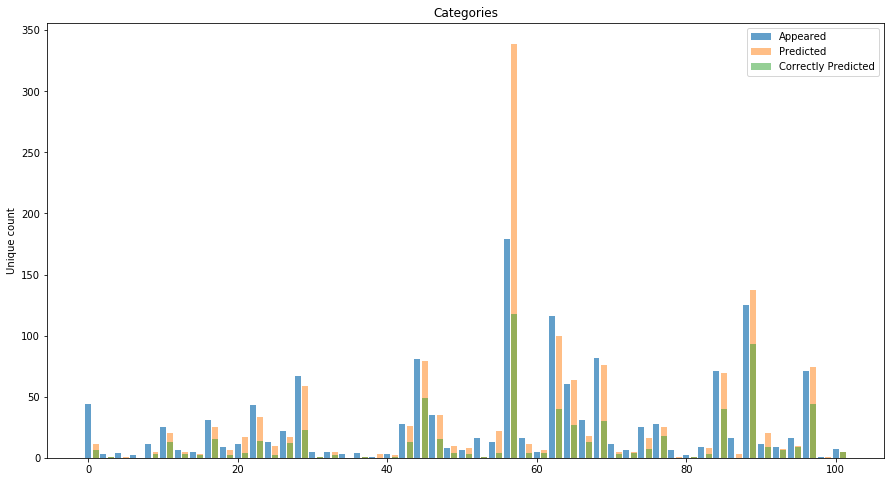

In [99]:
plt.figure(figsize=(15,8))
#plt.yscale('log')

plt.bar(yPosition, pod, alpha=0.7, label='Appeared')
plt.bar(yPosition, podp, alpha=0.5, label='Predicted')
plt.bar(yPosition, podc, alpha=0.5, label='Correctly Predicted')

plt.ylabel('Unique count')
plt.title('Categories')
plt.legend()
 
plt.show()

### Final prediction on all the training set and export

In [153]:
from sklearn.svm import LinearSVC
clf = LinearSVC(penalty = 'l2', max_iter = 1000, loss='squared_hinge', dual=True, tol=0.0001, C=1, verbose = 1)
clf = clf.fit(xTrain_tf, y)

[LibLinear]

In [156]:
exportY = clf.predict(xTest_tf)
exportY

array([29, 32, 28, ..., 28, 14, 34])

In [157]:
with open(os.path.join(dataDirPath, 'output_linearSVC.csv'), 'w+') as f:
    f.write('ID;intention\n')

    for i, p in enumerate(exportY):
        f.write('{};{}\n'.format(str(i), str(p)))